In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

In [ ]:
import sys
import time
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import imgaug as ia
import imgaug.augmenters as iaa
import cv2

In [ ]:
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg
from dataset_builder import DatasetBuilder

In [ ]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [ ]:
def prep_example(example):
  image = example['image']
  xs = example['keypoints/x']
  ys = example['keypoints/y']
  return image, xs, ys

In [ ]:
ds = tf.data.TFRecordDataset(ds_builder.train_filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) #create dataset
ds = ds.map(ds_builder.parse_tfrecord_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds = ds.map(prep_example, num_parallel_calls = tf.data.experimental.AUTOTUNE )

In [ ]:
example = ds.take(1)

In [ ]:
it = iter(example)
image, xs, ys = next(it)

In [ ]:
height = image.get_shape()[0]
width = image.get_shape()[1]

In [ ]:
corner_xs = tf.constant([0, width-1, 0,        width-1], dtype = tf.float32)
corner_ys = tf.constant([0, 0,       height-1, height], dtype = tf.float32)

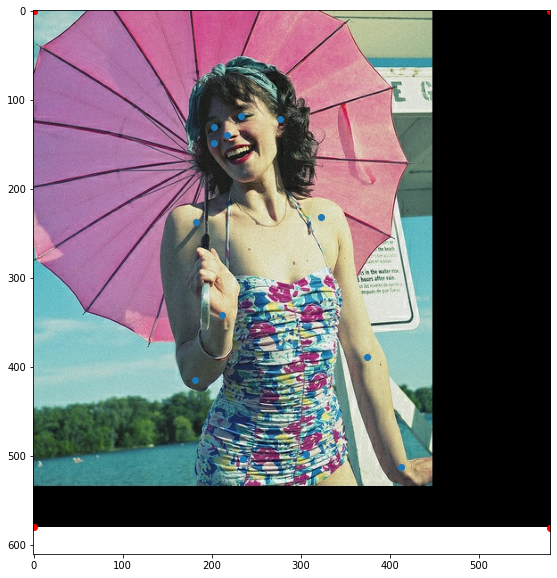

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(xs, ys)
plt.scatter(corner_xs, corner_ys, color = 'red')

In [ ]:
points = tf.stack([xs , ys], axis = 1)
points

<tf.Tensor: shape=(17, 2), dtype=float32, numpy=
array([[217.85875, 139.25874],
       [232.85875, 118.25875],
       [202.85875, 130.25874],
       [276.85876, 122.25875],
       [202.85875, 148.25874],
       [322.85876, 232.25874],
       [182.85875, 237.25874],
       [374.85876, 389.25876],
       [180.85875, 415.25876],
       [412.85876, 512.2587 ],
       [211.85875, 342.25876],
       [305.85876, 498.25876],
       [234.85875, 503.25876],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ],
       [  0.     ,   0.     ]], dtype=float32)>

In [ ]:
rotated_xs = tf.slice(rotated, [0, 0], [-1, 1])
tf.reshape(rotated_xs, shape = (17))

In [ ]:
rotated_ys = tf.slice(rotated, [0, 1], [-1, 1])
tf.reshape(rotated_ys, shape = (17))

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([229.53098, 218.84445, 214.23676, 244.30856, 229.8252 , 362.57135,
       296.90146, 524.53735, 450.05402, 650.0585 , 402.33417, 584.4341 ,
       553.2642 ,   0.     ,   0.     ,   0.     ,   0.     ],
      dtype=float32)>

In [ ]:
new_xs, new_ys = rotate_points(xs, ys, 30, image.get_shape()[1], image.get_shape()[0])

In [ ]:
new_xs

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([151.9702 , 154.4606 , 134.47983, 194.56572, 143.47983, 289.4029 ,
       170.65932, 412.93622, 257.92728, 507.34515, 248.27406, 407.68045,
       348.69263,   0.     ,   0.     ,   0.     ,   0.     ],
      dtype=float32)>

In [ ]:
new_ys

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([195.84186, 170.15533, 195.54764, 151.61943, 211.13608, 223.8822 ,
       298.21234, 333.8482 , 453.36487, 421.36932, 374.64502, 462.745  ,
       502.5751 , 184.16963, 184.16963, 184.16963, 184.16963],
      dtype=float32)>

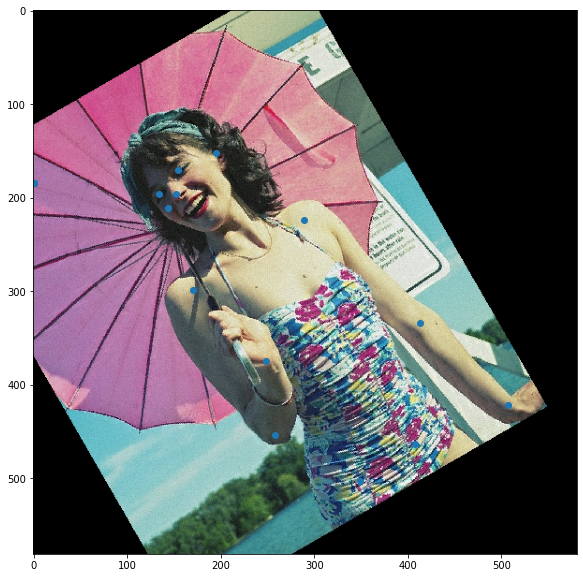

In [ ]:
rotate = tfa.image.rotate(image, tf.constant((np.pi/180)*30))
plt.figure(figsize = (10, 10))
plt.scatter(new_xs, new_ys)
plt.imshow(rotate)

In [ ]:
scale_factor = 1.25
target_width = image.get_shape()[1] * scale_factor
target_height = image.get_shape()[0] * scale_factor
new_image = image
if scale_factor < 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.pad_to_bounding_box(new_image, 144//2, 144//2, 581, 581)
elif scale_factor > 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.crop_to_bounding_box(new_image, 144, 144, 581, 581)

In [ ]:
image.get_shape()

TensorShape([581, 581, 3])

In [ ]:
new_image.get_shape()

TensorShape([581, 581, 3])

In [ ]:
corner_xs*1.25 - 144

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-144.,  581., -144.,  581.], dtype=float32)>

Text(0.5, 1.0, 'original')

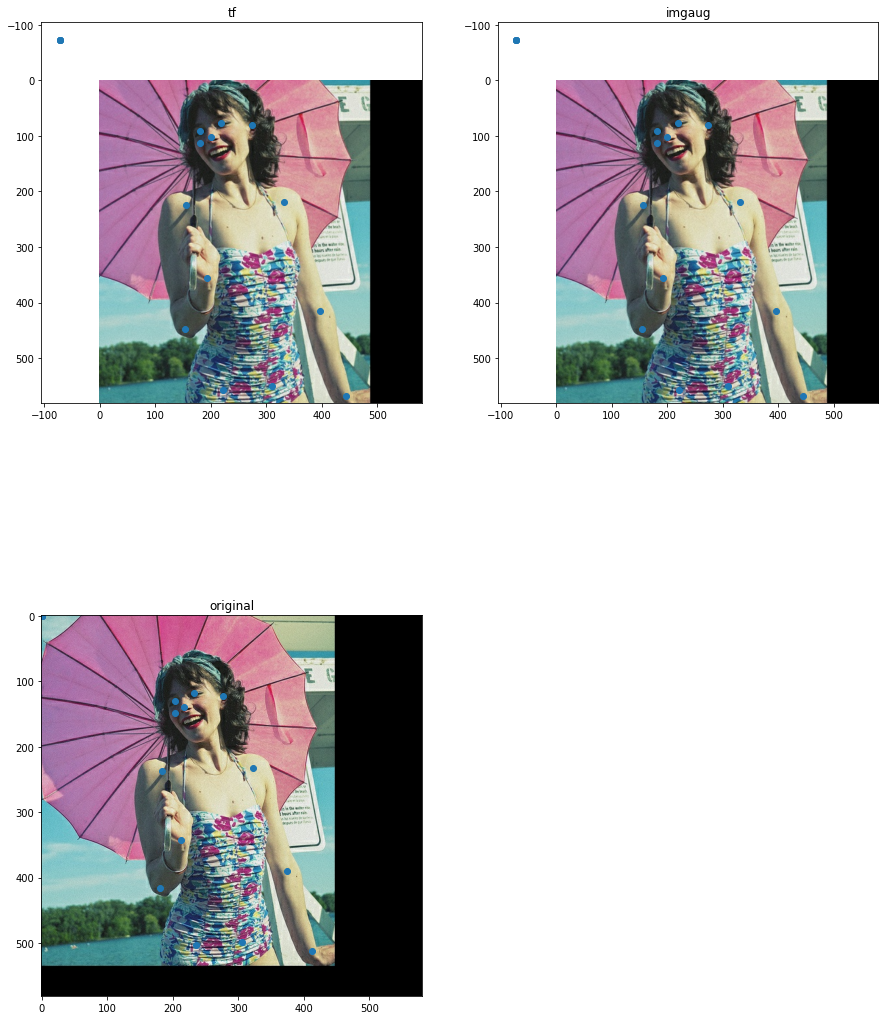

In [ ]:
scale_factor = 1.25
target_width = image.get_shape()[1] * scale_factor
target_height = image.get_shape()[0] * scale_factor
new_image = image
if scale_factor < 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.pad_to_bounding_box(new_image, 144//2, 144//2, 581, 581)
elif scale_factor > 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.crop_to_bounding_box(new_image, 144//2, 144//2, 581, 581)


seq = iaa.Sequential([
      #iaa.Fliplr(0.5),
      iaa.Affine(scale = (1.25, 1.25))
      ],)

imgaug = seq(image = image.numpy())

fig = plt.figure(figsize = (15, 20))

fig.add_subplot(2, 2, 1)
plt.imshow(new_image)
plt.scatter(xs*1.25 - 144//2, ys*1.25 - 144//2)
plt.title('tf')

fig.add_subplot(2, 2, 2)
plt.imshow(imgaug)
plt.scatter(xs*1.25 - 144//2, ys*1.25 - 144//2)
plt.title('imgaug')

fig.add_subplot(2, 2, 3)
plt.imshow(image)
plt.scatter(xs, ys)
plt.title('original')


Text(0.5, 1.0, 'original')

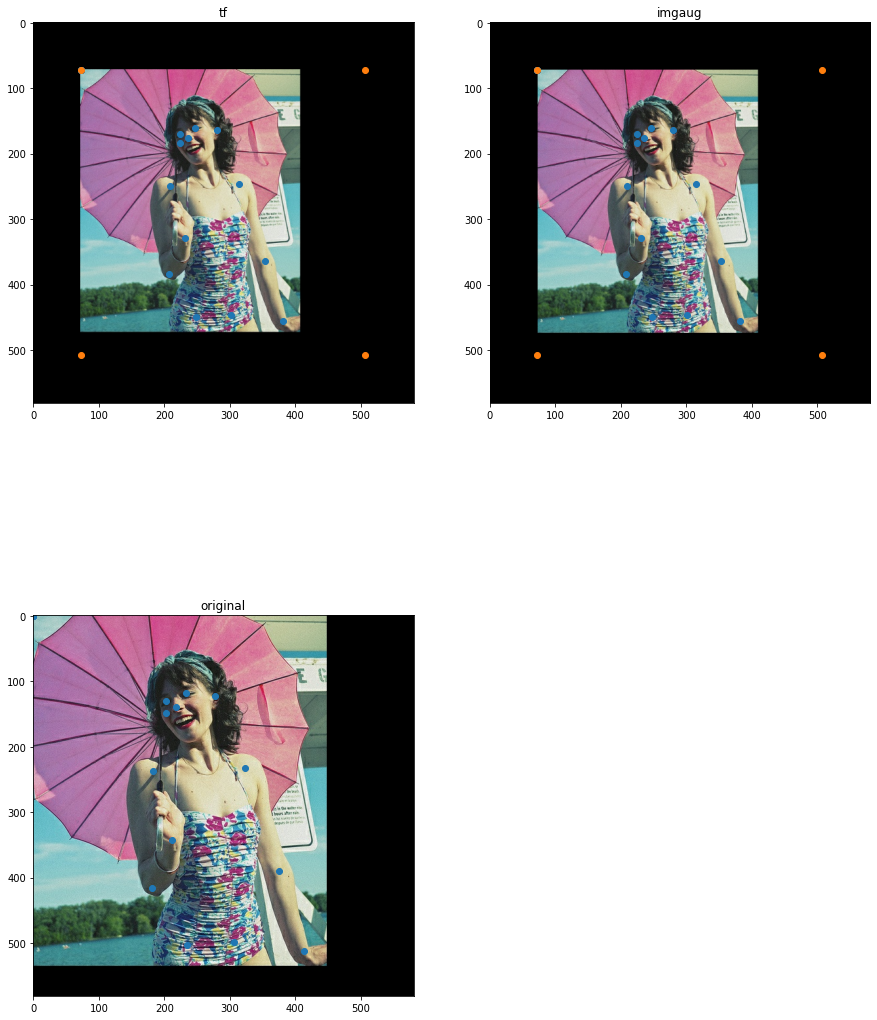

In [ ]:
scale_factor = 0.75
target_width = image.get_shape()[1] * scale_factor
target_height = image.get_shape()[0] * scale_factor
new_image = image
if scale_factor < 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.pad_to_bounding_box(new_image, 144//2, 144//2, 581, 581)
elif scale_factor > 1.0:
  new_image = tf.image.resize(image, size = (int(target_height), int(target_width)))
  new_image = tf.image.crop_to_bounding_box(new_image, 144, 144, 581, 581)

seq = iaa.Sequential([
      #iaa.Fliplr(0.5),
      iaa.Affine(scale = (0.75, 0.75))
      ],)
imgaug = seq(image = image.numpy())


fig = plt.figure(figsize = (15, 20))

fig.add_subplot(2, 2, 1)
plt.imshow(new_image)
plt.scatter(xs*0.75 + 144//2, ys*0.75 + 144//2)
plt.scatter(corner_xs*0.75 + 144//2, corner_ys*0.75 +144//2)
plt.title('tf')

fig.add_subplot(2, 2, 2)
plt.imshow(imgaug)
plt.scatter(xs*0.75 + 144//2, ys*0.75 + 144//2)
plt.scatter(corner_xs*0.75 + 144//2, corner_ys*0.75 +144//2)
plt.title('imgaug')

fig.add_subplot(2, 2, 3)
plt.imshow(image)
plt.scatter(xs, ys)
plt.title('original')


In [ ]:
for i in range(10):
  tf.random.set_seed(i)
  tf.print(tf.random.uniform(shape = [1], minval = 0, maxval = 2, dtype = tf.int32, seed = i), end = ', ')

[0], [0], [0], [1], [1], [0], [1], [0], [0], [0], 

In [ ]:
for i in range(10):
  tf.print(tf.random.uniform(shape = [1], minval = 0, maxval = 2, dtype = tf.int32), end = ', ')

[1], [0], [0], [0], [1], [1], [0], [0], [1], [0], 

In [ ]:
def rotate_points(xs, ys, width, height, angle):
  '''
  Usage: 
    Rotate a set of points within bond (width and height) around the center
    The function also eleminate all the points out of bound after rotation
    Doesnt work with batch

  Params:
    xs, ys: Tensors, expected to be in the same shape (number of points)
    width, height: bound that points exist within
    angle: angle to roate in radians, positive -> counter-closewise and otherwise

  Returns:
    Two tensors for x and y coordinates

  Throws:

  '''
  number_of_points = tf.cast(tf.shape(xs), dtype = tf.int32)

  # Mask invisible points (out of bound)
  mask_xs = tf.cast(xs > 0, dtype = tf.float32)
  mask_ys = tf.cast(ys > 0, dtype = tf.float32)
  mask = mask_xs * mask_ys
  
  # Find center
  center_x = width / 2
  center_y = height / 2
  # Stack for matrix multiplication and center the points
  points  = tf.stack([xs - center_x , ys - center_y], axis = 1) # shape (num of points, 2)

  # Convert to radians
  rotation_matrix = tf.stack([(tf.cos(angle), -tf.sin(angle)),
                              (tf.sin(angle), tf.cos(angle))], axis=0)

  rotated_points =  tf.matmul(points, rotation_matrix)

  # Extract, reshape and apply mask
  rotated_xs = tf.slice(rotated_points, [0, 0], [-1, 1]) + center_x 
  rotated_xs = tf.reshape(rotated_xs, shape = (number_of_points)) 
  rotated_xs = rotated_xs * mask

  rotated_ys = tf.slice(rotated_points, [0, 1], [-1, 1]) + center_y
  rotated_ys = tf.reshape(rotated_ys, shape = (number_of_points))
  rotated_ys = rotated_ys * mask

  return rotated_xs, rotated_ys
 


In [ ]:
new_x, new_y = rotate_points(xs, ys, width, height, 30)
tf.print(new_x)
tf.print(new_y)

In [ ]:
def rotate(image, width, height, xs, ys, angle):
  '''
  Usage: 
    Rotate image and points inside the image by and angle

  Args:
    image: a Tensor 
    xs, ys: Tensors, expected to be in the same shape (number of points)
    width, height, tf.int32 tensors
    angle: angle to rotate in radians, positive -> counter-closewise and otherwise

  Returns:
    Rotated image, xs, ys

  '''
  # Covert to float
  _width = tf.cast(width, dtype = tf.float32)
  _height = tf.cast(height, dtype = tf.float32)

  rotated_image = tfa.image.rotate(image, tf.constant(angle))
  rotated_xs, rotated_ys = rotate_points(xs, ys, _width, _height, angle)

  return rotated_image, rotated_xs, rotated_ys 

In [ ]:
rotated = rotate(image, xs, ys, 30 * (np.pi / 180.0))

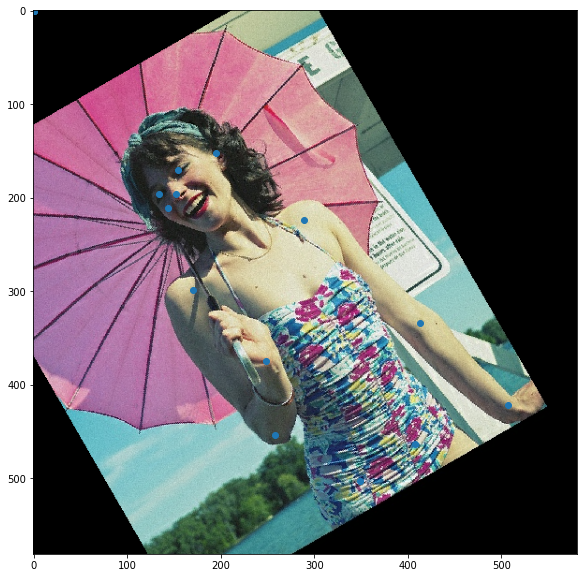

In [ ]:
plt.figure(figsize = (10, 10))
plt.scatter(rotated[1], rotated[2])
plt.imshow(rotated[0])

In [ ]:
def scale(image, width, height, xs, ys, scale_factor):
  '''
  Usages:
    Scale image evenly on both axis
    Also adjust xs, ys accordlingy
    Does not support batch
  
  Args:
    image: a tf.float32 tensor, expected to be a square
    width, height: tf.int32 tensor
    xs, ys: tf.float32 tensor
    scale_factor: a float
  
  Returns:
    Scaled image, xs, ys

  Throws: 

  '''
  # Mask invisible points (out of bound)
  mask_xs = tf.cast(xs > 0, dtype = tf.float32)
  mask_ys = tf.cast(ys > 0, dtype = tf.float32)
  mask = mask_xs * mask_ys

  # Convert to float
  original_width = tf.cast(width, dtype = tf.float32)
  original_height = tf.cast(height, dtype = tf.float32)

  new_width = scale_factor * original_width
  new_height = scale_factor * original_height

  offset_width = tf.math.abs(original_width - new_width)
  offset_height = tf.math.abs(original_height - new_height)

  scaled_image = tf.image.resize(image, size = tf.stack(int(new_height), int(new_height)))
  scaled_xs = xs * scale_factor
  scaled_ys = ys * scale_factor
  
  # if smaller than 1.0, resize to smaller size and then pad with 0s to the orginal size
  if scale_factor < 1.0:
    # Deal with image
    scaled_image = tf.image.pad_to_bounding_box(scaled_image, int(offset_height//2), int(offset_width//2), 
                                                               int(original_height), int(original_width))
    # Deal with point
    scaled_xs = scaled_xs + offset_width//2
    scaled_ys = scaled_ys + offset_width//2

  # if greater than 1.0, resize to bigger size and then crop to the orginal size
  elif scale_factor > 1.0:
    # Deal with image
    scaled_image = tf.image.crop_to_bounding_box(scaled_image, int(offset_height//2), int(offset_width//2), 
                                                                int(original_height), int(original_width))
    # Deal with point
    scaled_xs = scaled_xs - offset_width//2
    scaled_ys = scaled_ys - offset_width//2
  
  # if 1.0, do nothing

  return scaled_image, scaled_xs*mask, scaled_ys*mask

In [ ]:
scaled = scale(image, xs, ys, 0.75)
i = rotate(scaled[0], scaled[1], scaled[2], 30 * (np.pi / 180.0))

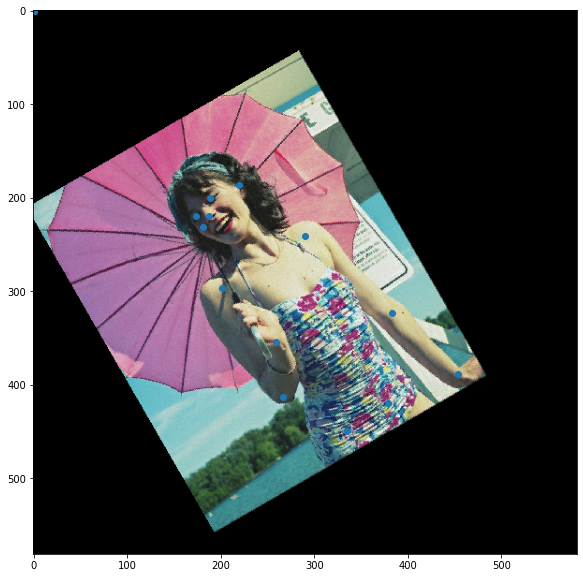

In [ ]:
plt.figure(figsize = (10, 10))
plt.scatter(i[1], i[2])
plt.imshow(i[0])

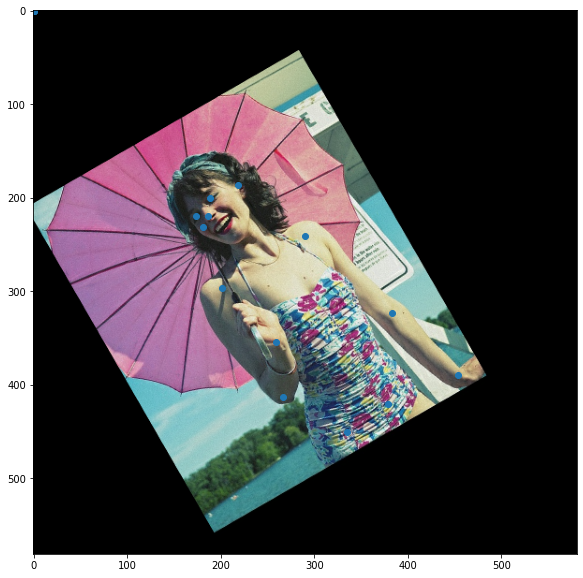

In [ ]:
seq = iaa.Sequential([
      #iaa.Fliplr(0.5),
      iaa.Affine(scale = (0.75, 0.75), rotate=-30)
      ],)

imgaug = seq(image = image.numpy())
plt.figure(figsize = (10, 10))
plt.scatter(scaled[1], scaled[2])
plt.imshow(imgaug)

In [ ]:
def flip_left_to_right(image, width, xs):
  '''
  Usages:
    Simply flip an image, xs around the center along the width
  
  Args:
    image: Tensor type tf.float32
    width: Tensor type tf.int32
    xs: Tensor type tf.float32
  
  Return:
    Flipped image, xs
  
  '''
  # Deal with image
  flipped_image = tf.image.flip_left_right(image) 

  flipped_xs = tf.cast(width, dtype = tf.float32) - xs

  return flipped_image, flipped_xs

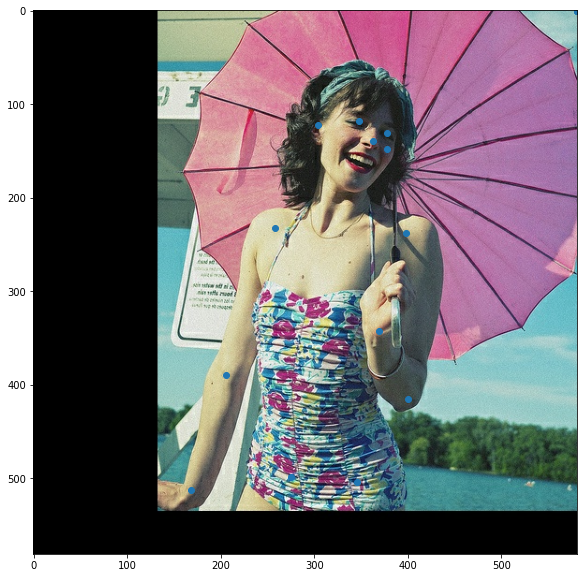

In [ ]:
flipped = (image, xs)
if tf.random.uniform(shape = [1], minval = 0, maxval = 2, dtype = tf.int32):
    flipped = flip_left_to_right(image, xs)

plt.figure(figsize = (10, 10))
plt.scatter(flipped[1], ys)
plt.imshow(flipped[0])

In [ ]:
# scale then rotate
img, x, y = scale(flipped[0], flipped[1], ys, 1.25)
img, x, y = rotate(img, x, y, -30 * (np.pi / 180.0) )
plt.figure(figsize = (10, 10))
plt.scatter(x, y)
plt.imshow(img)

In [ ]:
def augment(image, xs, ys):
  # Get width and height: int32 tensors
  width = tf.shape(image)[1]
  height = tf.shape(image)[0]

  # Random flip along width
  aug_img, aug_xs = image, xs
  flipped = tf.random.uniform(shape=[1], minval=0, maxval=2, dtype=tf.int32)
 
  if flipped > 0:
    aug_img, aug_xs = flip_left_to_right(image, width, xs)

  # Scale need to be performed before rotate
  random_factor = tf.random.uniform(shape=[1], minval=0.75, maxval=1.25, dtype=tf.float32)
  aug_img, aug_xs, aug_ys = scale(aug_img, width, height, aug_xs, ys,random_factor)

  # Rotate
  random_angle = tf.random.uniform(shape=[1], minval=-30, maxval=30, dtype=tf.float32)
  radians = 30 * (np.pi/180.0)
  aug_image, aug_xs, aug_ys = rotate(aug_img, width, height, aug_xs, aug_ys, radians)

  return aug_image, aug_xs, aug_ys


In [ ]:
ds = tf.data.TFRecordDataset(ds_builder.train_filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) #create dataset
ds = ds.map(ds_builder.parse_tfrecord_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds = ds.map(prep_example, num_parallel_calls = tf.data.experimental.AUTOTUNE )
ds = ds.map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)

OperatorNotAllowedInGraphError: ignored

In [ ]:
it = iter(ds)

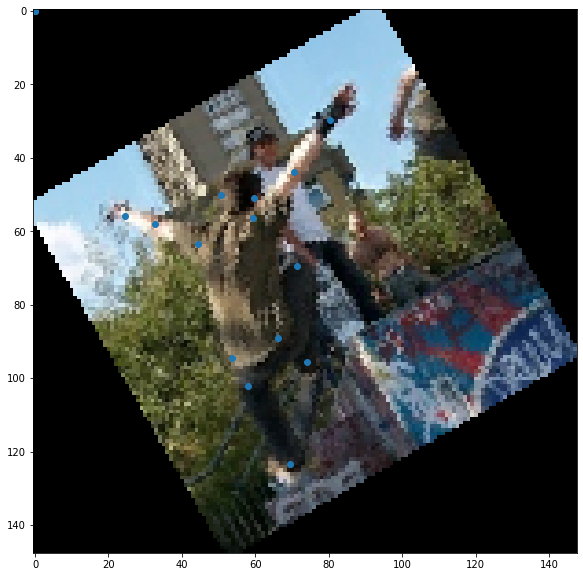

In [ ]:
img, xs, ys = next(it)
plt.figure(figsize = (10, 10))
plt.scatter(xs, ys)
plt.imshow(img)